## Visualize OTFs

This notebook is used to visualize, explore and troubleshoot OTFs that were generated from the ```radialft``` utility. 

The utility takes in a 3D image of a bead that contains 5 phases and 1 direction.

The output is a no by nr by nz image which contains the radially averaged 3D OTF as a nr by nz 2D image, and contains a radially averaged OTF for each order.

In [2]:
import mrc as Mrc
from scipy.fftpack import fftn, fftshift
import numpy as np
from tnia.plotting.projections import show_xyz_slice
from tnia.plotting.projections import show_xyz_slice_center 
import matplotlib.pyplot as plt
import os

## Define OTF Name and load the MRC file

In [3]:
#otf_name = r'D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\ims\computed_OTF_folder\488nmLin403OTF0.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\code\simrecon\test_data\otf.dv'
otf_name = r'D:\Janelia\Data For Brian\Cryo-SIM Scope #2 Data (James System)\PSFs (best PSFs and examples of bad ones)\BEAD 2 - NON-AR 1.2W 25ms retake_20240503_170242 GOOD PSF!!\computed_OTF_folder\488nmLinOTF0.mrc'
#otf_name = r'D:\Janelia\Data For Brian\Cryo-SIM Scope #1 Data (Ground truth baseline)\Ground truth OTFs System #1\488 OTF Bead 8_20190919_141256.mrc'
#otf_name = r'C:\Users\bnort\work\Janelia\ims\cropped_MRC\from_debugger.mrc'
#otf_name = r'D:\Janelia\Data 2024-06-03\PSF-OTF used (Davids set of 4 wavelengths)\201909_19-20_best\488 OTF Bead 8_20190919_141256.mrc'

otf_mrc = Mrc.Mrc(otf_name)
otf_data = otf_mrc.data
print(otf_data.shape, otf_data.dtype)
otf_mrc
sxy, sxy, sz = otf_mrc.header.d[0], otf_mrc.header.d[1], otf_mrc.header.d[2]
print(sxy, sxy, sz)

(3, 81, 65) >c8
0.048076924 0.048076924 0.0


## Visualize OTF and PSF

For each order visualize both the OTF and PSF.  

1.  Perform an inverse real FFT so we can display and troubleshoot the PSF 

2.  take the transpose of the PSF then perform a complex FFT so that we can get look at the FFT in the same format as displayed in Gustafsson/Shao et. al 2008 page 4961.
 

(65, 160)


C:\Users\bnort\AppData\Local\Temp\ipykernel_9488\270955196.py:17: RuntimeWarning: divide by zero encountered in log
  otfs_log = [np.log(otfs_abs[i]) for i in range(otf_data.shape[0])]


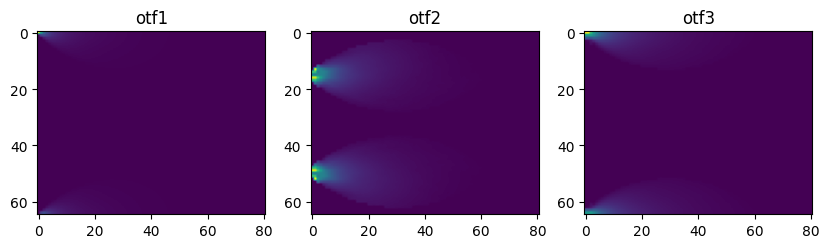

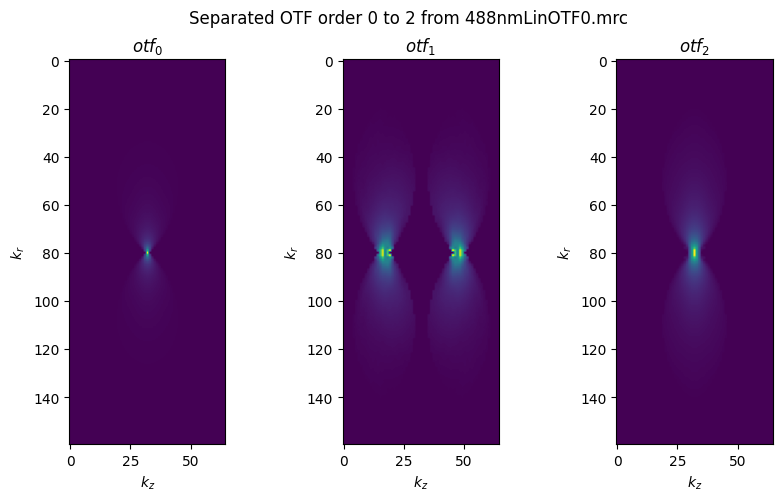

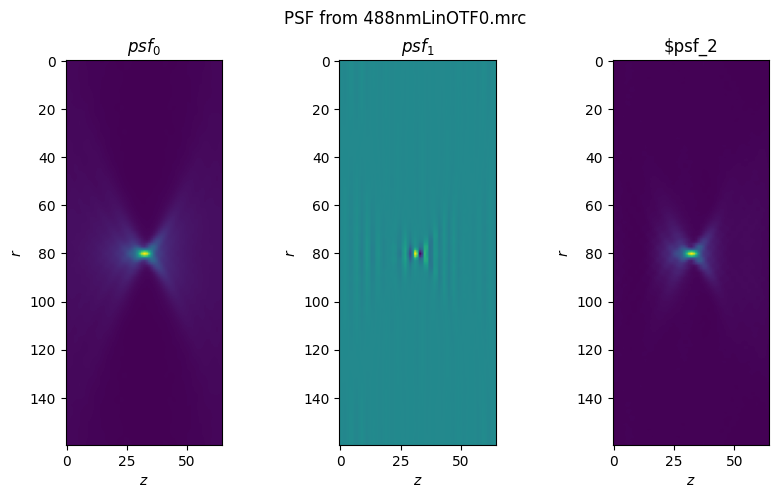

In [15]:
from matplotlib.pyplot import ylabel
from tnia.plotting.plt_helper import imshow_multi2d
otf = [np.transpose(otf_data[i,:,:] ) for i in range(otf_data.shape[0])]
otf_abs = [np.abs(otf[i]) for i in range(otf_data.shape[0])]
fig = imshow_multi2d(otf_abs, ['otf1', 'otf2', 'otf3'], 1 ,3)

real_shape = ( otf[0].shape[0], (otf[0].shape[1]-1)*2)
print(real_shape) 

psfs = [np.fft.irfftn(o, s=real_shape) for o in otf]
psfs_list = psfs
psfs = [np.transpose(psf) for psf in psfs]
otfs = [np.fft.fftn(psf) for psf in psfs]
otfs_abs = [np.abs(fftshift(otfs[i])) for i in range(otf_data.shape[0])]
delta = 0
for o in otfs_abs: o[o<delta] = delta 
otfs_log = [np.log(otfs_abs[i]) for i in range(otf_data.shape[0])]
psfs_shift = [fftshift(psf) for psf in psfs]
fig = imshow_multi2d(otfs_abs, [f'$otf_0$', f'$otf_1$', f'$otf_2$'], 1 ,3, xlabels = [f'$k_z$', '$k_z$', '$k_z$'], ylabels = [f'$k_r$', '$k_r$', '$k_r$'], height = 5)
fig.suptitle('Separated OTF order 0 to 2 from '+os.path.basename(otf_name))
fig.savefig(r'D:\Janelia\Data 2024-06-12\band_figures\separated_otfs.png')
fig = imshow_multi2d(psfs_shift, ['$psf_0$', '$psf_1$', '$psf_2'], 1 ,3, xlabels = [f'$z$', '$z$', '$z$'], ylabels = [f'$r$', '$r$', '$r$'], height = 5)
fig.suptitle('PSF from '+os.path.basename(otf_name))
fig.savefig(r'D:\Janelia\Data 2024-06-12\band_figures\separated_psfs.png')

#otf_ = [np.fft.fftn(psf) for psf in psfs]
#fig = imshow_multi2d([np.abs(otf_[i]) for i in range(otf.shape[0])], ['otf1', 'otf2', 'otf3'], 1 ,3)

## Visualize in Napari

In [7]:
import napari
viewer = napari.Viewer()
viewer.add_image(np.abs(otf_data[1,:,:]))

<Image layer 'Image' at 0x214b2a65b50>

## Draw line profile through center of second order PSF

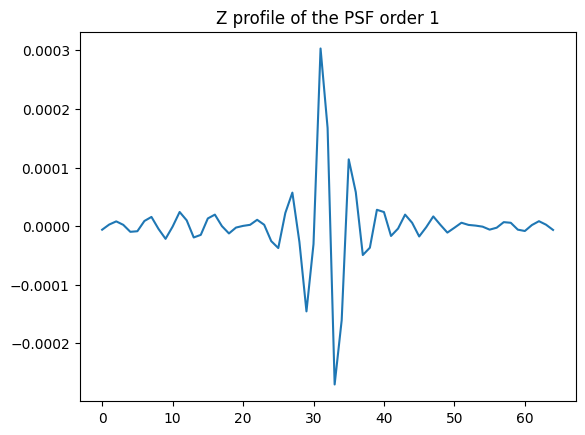

In [19]:
array = psfs_shift[1]

# Find the index of the maximum value in the flattened array
max_index_flat = np.argmax(array)

# Convert the flat index to a tuple of indices
max_index = np.unravel_index(max_index_flat, array.shape)

z_profile = array[max_index[0], :]

plt.plot(z_profile)
plt.title('Z profile of the PSF order 1')
plt.savefig(r'D:\Janelia\Data 2024-06-12\band_figures\z_profile_psf_order_1.png')


## Draw line profiles of all three orders

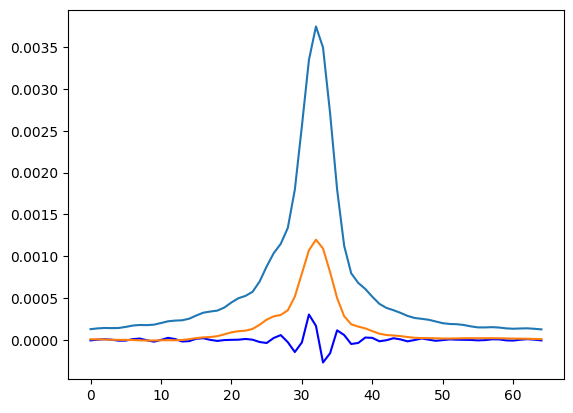

In [18]:

fig, ax = plt.subplots()
x = np.arange(0, psfs[0].shape[1])
y = psfs_shift[0][psfs[0].shape[0]//2,:]
ax.plot(x, y, label='order 1')
y = psfs_shift[1][psfs[1].shape[0]//2,:]
ax.plot(x, y, label='order 2', color='blue')
y = psfs_shift[2][psfs[2].shape[0]//2,:]
ax.plot(x, y, label='order 3')

In [13]:
import napari
viewer = napari.Viewer()
viewer.add_image(psfs[0], name='order 1')
viewer.add_image(psfs[1], name='order 2')
viewer.add_image(psfs[2], name='order 3')

<Image layer 'order 3' at 0x1f7f2a321f0>

In [14]:
for psf in psfs:
    print(psf.sum())

1.0
2.6020852139652106e-18
0.04312517121434212


In [15]:
from skimage.io import imsave
psf_name = r'D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best_psf.tif'

In [23]:
imsave(psf_name, psf)

c:\Users\bnort\miniconda3\envs\simrecon_python_373\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best_psf.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [16]:
for psf in psfs_shift:
    print(psf.min(), psf.max(), psf.sum())

-5.83001946940908e-06 0.0035583743167010725 1.0
-0.0008576229355919798 0.0006462752785049967 6.505213034913027e-19
-3.174347996488636e-06 0.0003416930612239902 0.04312517121434212


In [17]:
otf_data.shape

(3, 65, 65)

In [18]:
from scipy.ndimage import rotate


def make_symmetric_3d(image_2d):
    size_z = image_2d.shape[0]
    size_y = image_2d.shape[1]
    symmetric_3d = np.zeros((size_z, size_y, size_y))

    for i in range(size_y):
        angle = (360 / size_y) * i
        rotated_slice = rotate(image_2d, angle, reshape=False)
        symmetric_3d[i] = rotated_slice

    return symmetric_3d

In [19]:
temp = np.fft.ifftshift(psfs_[1])
plt.imshow(temp)

NameError: name 'psfs_' is not defined

In [20]:

z_coords_, y_coords_ = np.meshgrid(z, y, indexing='ij')
stop = 5

NameError: name 'z' is not defined

In [21]:
from scipy.interpolate import LinearNDInterpolator



def sample_2d_at_3d(image_2d, z, y, x, interp):
    x = np.abs(x - image_2d.shape[1]//2)
    y = np.abs(y - image_2d.shape[1]//2)
    r = np.sqrt(y**2 + x**2)
    index = image_2d.shape[1]//2 +r
    #r= int(r)
    if index<127:
        #val = image_2d[z, index]
        val = interp([z, index])
        return val
    else:
        return 0

(128, 65)
(128, 65)
(128, 65)


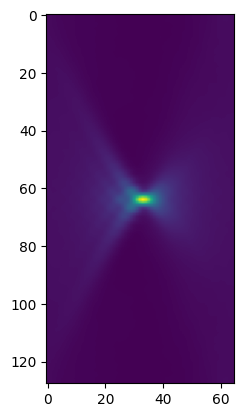

In [22]:
for psf in psfs:
    print(psf.shape)

plt.imshow(np.fft.ifftshift(psfs[0]))
    

In [23]:
psfs_3d = []

#z_coords, y_coords, x_coords = np.meshgrid(z, y, x, indexing='ij')

for psf in psfs:
    psf = np.transpose(psf)
    psf = np.fft.ifftshift(psf)
    three_d = np.zeros((65, 128, 128), dtype=np.float32)
    z = np.arange(three_d.shape[0])
    y = np.arange(three_d.shape[1])
    x = np.arange(three_d.shape[2])
    
    z_coords_, y_coords_ = np.meshgrid(z, y, indexing='ij')

    points = np.stack((z_coords_.flatten(), y_coords_.flatten()), axis=1)
    values = psf.flatten()
                  
    interp = LinearNDInterpolator(points, values)
    
    for i in range(three_d.shape[0]):
        for j in range(three_d.shape[1]):
            for k in range(three_d.shape[2]):
                three_d[i,j,k] = sample_2d_at_3d(psf, i, j, k, interp) 

    psfs_3d.append(three_d)


C:\Users\bnort\AppData\Local\Temp\ipykernel_71816\3329191234.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  three_d[i,j,k] = sample_2d_at_3d(psf, i, j, k, interp)


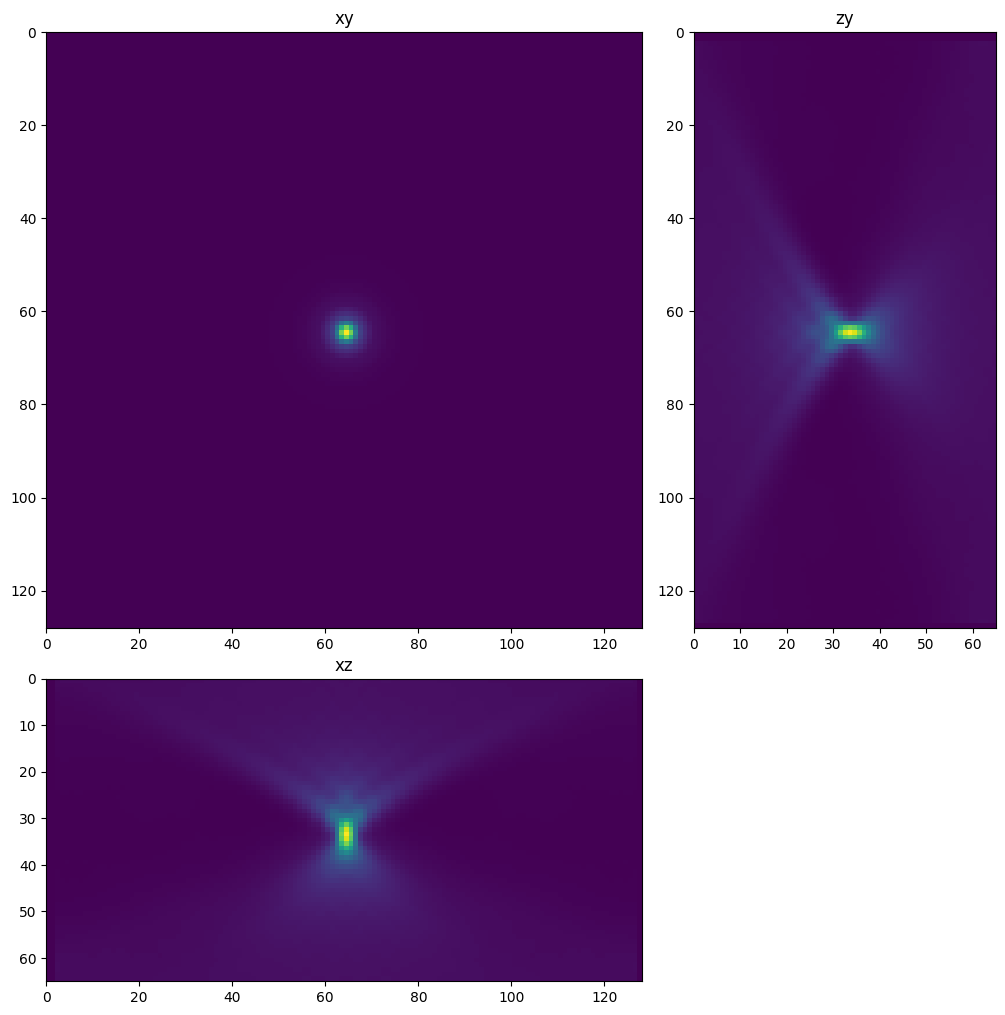

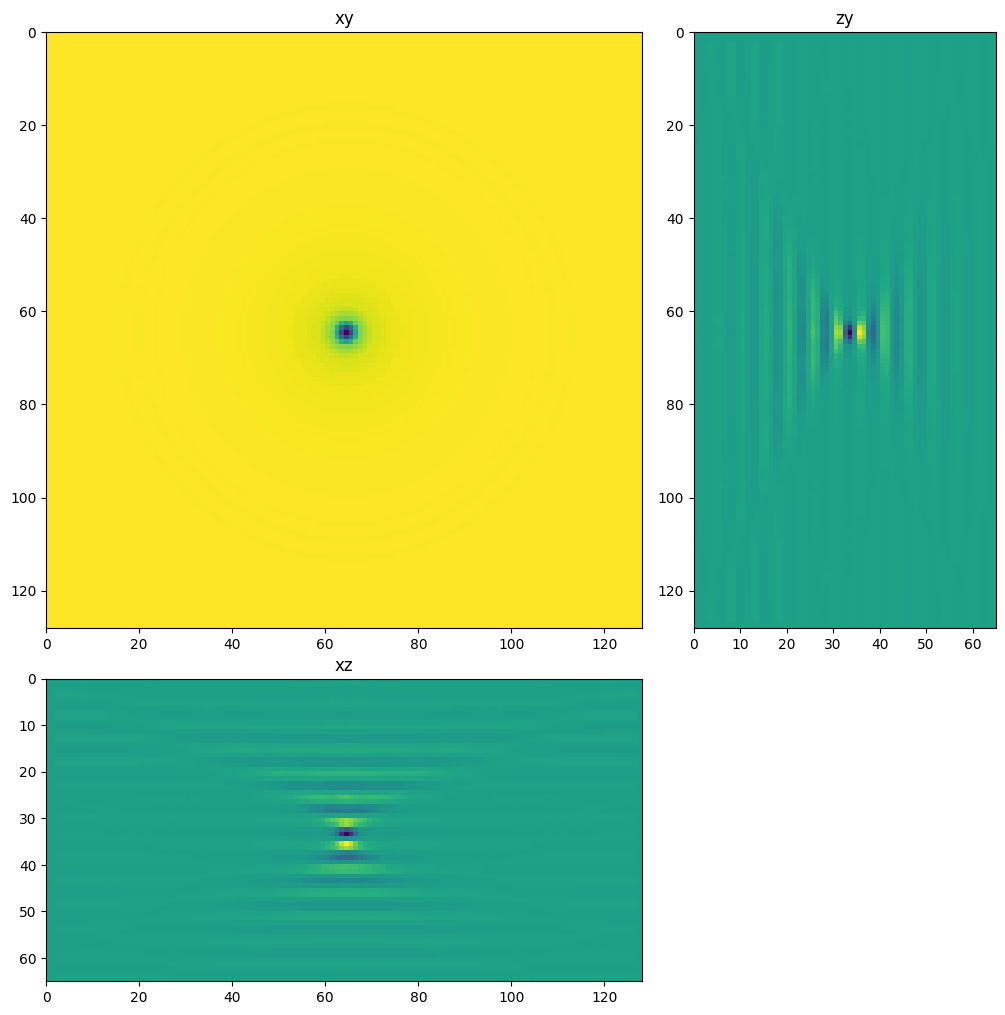

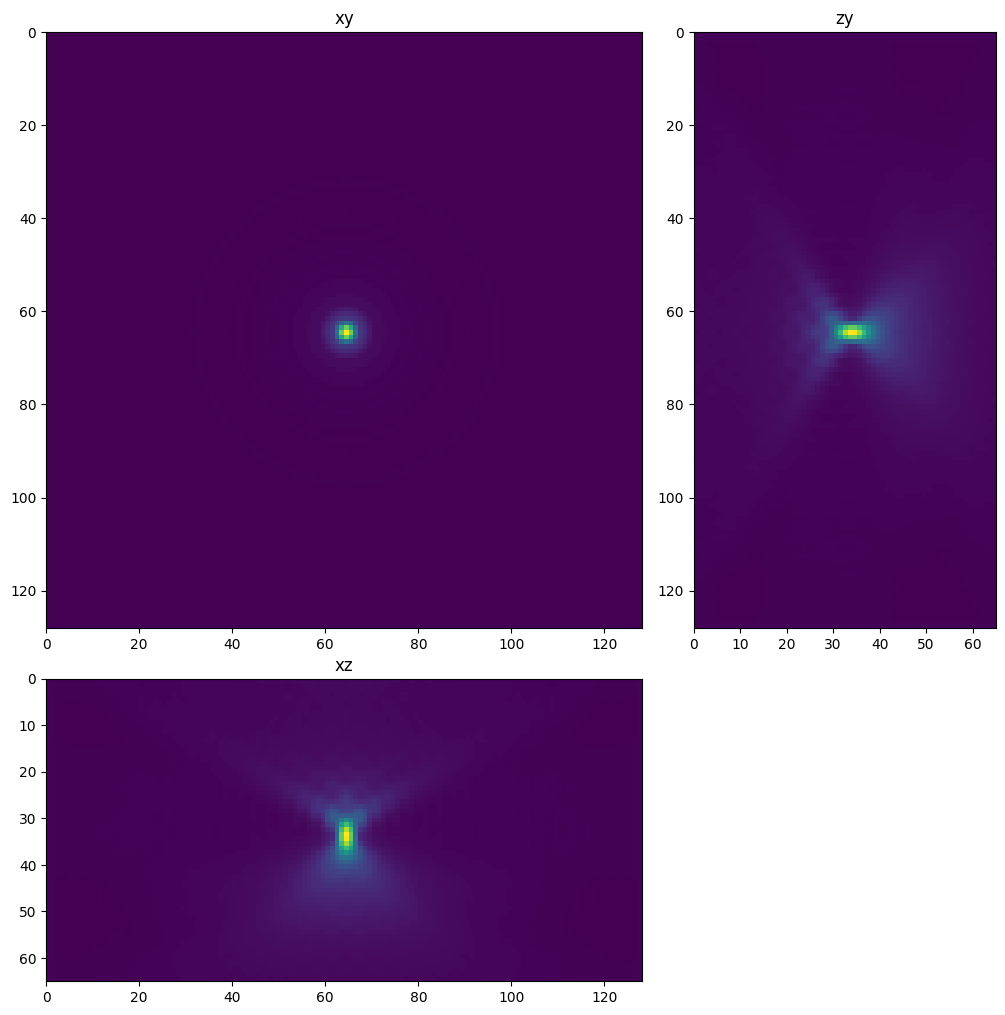

In [24]:
for psf_3d in psfs_3d:
    fig = show_xyz_slice_center(psf_3d)

In [25]:
from skimage.io import imsave

otf_path = os.path.dirname(otf_name)

print(otf_path)

for i , psf_3d in enumerate(psfs_3d):
    psf_name = os.path.join(otf_path, 'psf_3d_'+str(i)+'.tif')
    imsave(psf_name, psf_3d)


D:\Janelia\Data 2024-06-12\561nm OTF used


C:\Users\bnort\AppData\Local\Temp\ipykernel_71816\3341845897.py:9: UserWarning: D:\Janelia\Data 2024-06-12\561nm OTF used\psf_3d_0.tif is a low contrast image
  imsave(psf_name, psf_3d)
C:\Users\bnort\AppData\Local\Temp\ipykernel_71816\3341845897.py:9: UserWarning: D:\Janelia\Data 2024-06-12\561nm OTF used\psf_3d_1.tif is a low contrast image
  imsave(psf_name, psf_3d)
C:\Users\bnort\AppData\Local\Temp\ipykernel_71816\3341845897.py:9: UserWarning: D:\Janelia\Data 2024-06-12\561nm OTF used\psf_3d_2.tif is a low contrast image
  imsave(psf_name, psf_3d)


In [29]:
psfs_3d[0].dtype

dtype('float32')

In [26]:
print(psfs_3d[0].shape, psfs_3d[0].shape)

(65, 128, 128) (65, 128, 128)


In [27]:
from skimage.restoration import wiener

result = wiener(psfs_3d[0], psfs_3d[0], 0.1)
result.min(), result.max(), psfs_3d[1].min(), psfs_3d[1].max()

(-0.0003076197, 0.006327087, -0.00085762294, 0.0006462753)

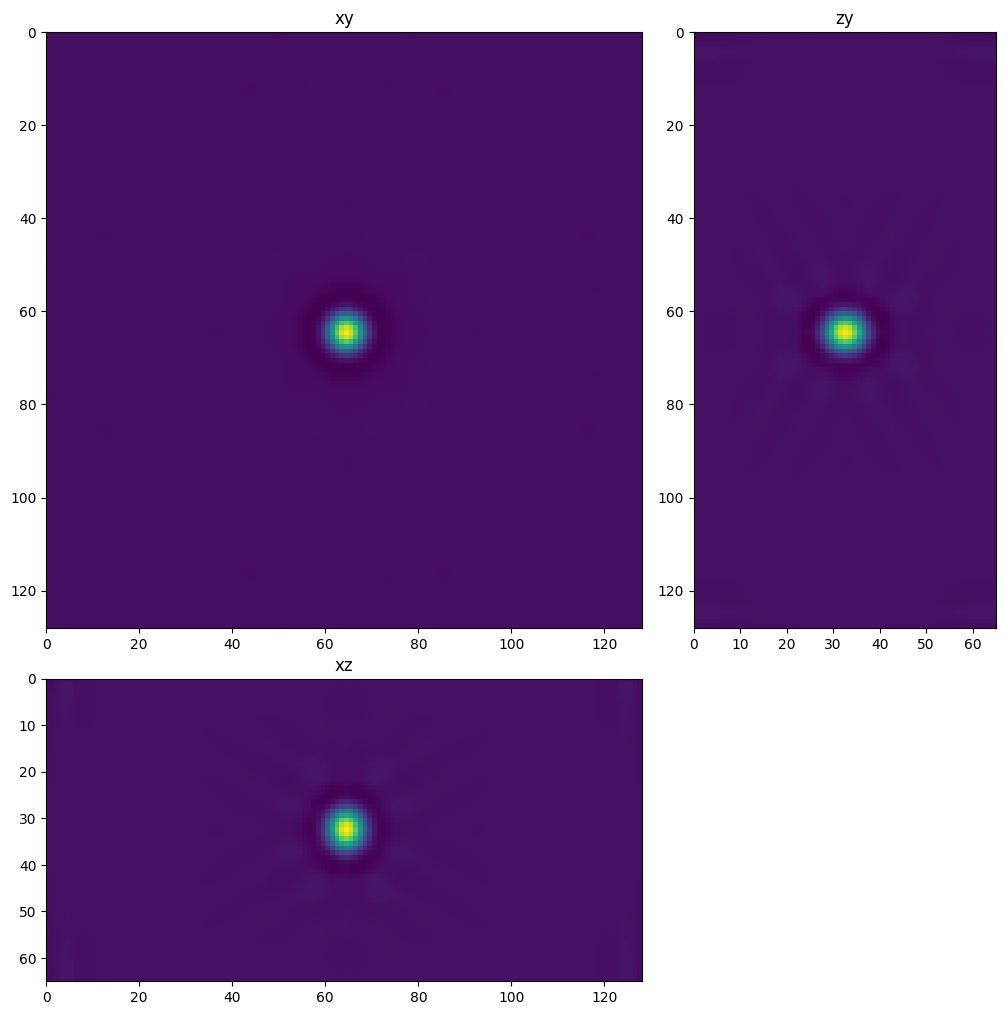

In [211]:
fig = show_xyz_slice_center(result)

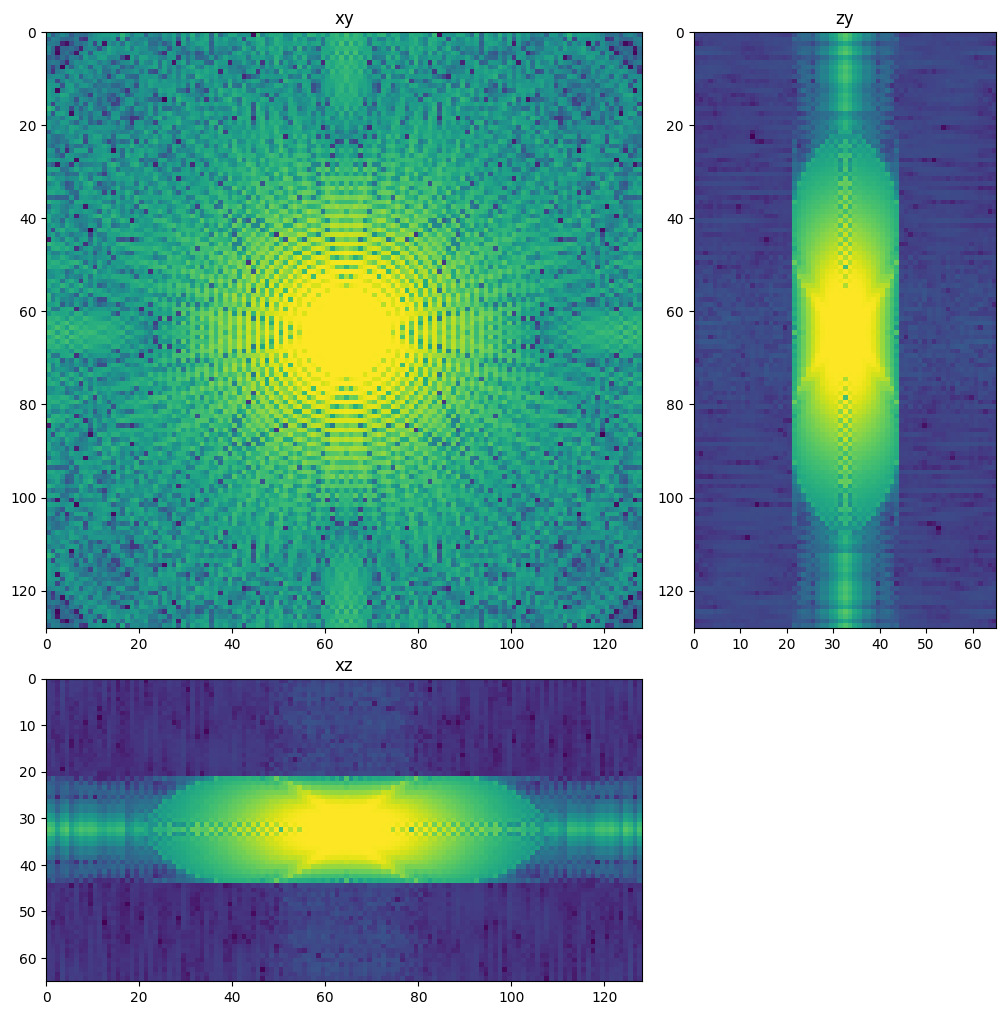

In [212]:
fft_result = np.fft.fftn(result)
fft_result = np.fft.fftshift(fft_result)
fft_result_abs = np.abs(fft_result)
fft_result_abs = np.log(fft_result_abs)

fig = show_xyz_slice_center(fft_result_abs)

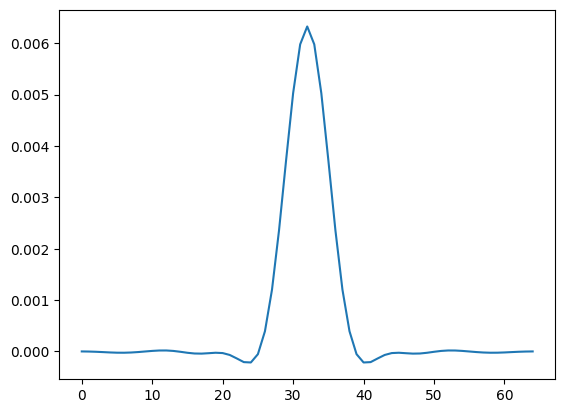

In [213]:
plt.plot(result[:, 64, 64])